# **Decision Trees: A Financial Application**

Decision trees are a supervised machine learning algorithm (supervised meaning the data is already classified as oppose to unspervised learning techniques) used for classification or regression tasks. 

## **High Level Overview**

Focusing on the classification case

key points:

- models descisions and their possible consequnces as a tree structure of decisions and their outcomes
- root node is first split
- each branch represents a decision rule (non leaf node)
- each internal node represents a feature
- each leaf node represents the outcome

Algorithm:
- Splitting Criteria: for classsifciation we split the dataset features based on their impurity
- Information Gain: from each split their is a reduction in impurity, we reduce this with the information gain formula  

Importnat notes for time series data and feature engineering
- Time series split: Canot random split / shuffle data when working with time series data, hence canot use traditional CV techniques
- Perfect scores: If we have a feature perfect match e.g. non lagged returns used to predict day state (posative or negative = up or down day) the feature providees complete informating on the traget leading to a model that preforms with 100% accuracy. This is beacause all posative returns will be posative day states and all negative returns the opposite. In reality we will not have future infomration on returns to feed through our model. i.e. our model is trained on feature it is trying to predict resulting in a direct mapping from returns to day state.

## **Decision Tree Implementation**

In [ ]:
# imports for tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
# !pip install --upgrade yfinance
# import yfinance as yf
import pandas as pd
import numpy as np
import yfinance as yf 

# imports for trading strategy backtest
from talib import ATR # ! pip install talib

In [ ]:
# data
data = yf.download(tickers='TSLA', start="2019-01-01", end="2023-12-31")
sp500 = yf.download(tickers='^GSPC', start="2019-01-01", end="2023-12-31")
sp500.rename(columns={'Close': 'Close_sp500'}, inplace=True) # inplace returns original dataframe inted of new
data = pd.DataFrame(pd.concat([data, sp500['Close_sp500']], axis=1))

data.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in data.columns]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


features, we shift past feature values into the present

In [ ]:
# Lagged rounded returns
data['returns'] = data['Close_TSLA'].pct_change() * 100
data['returns_prior'] = data['returns'].shift(1)  # To evaluate optimal lags use ACT and PCF

# Bar range
data['range_standerdised'] = ((data['High_TSLA'] - data['Close_TSLA']) / (data['High_TSLA'] - data['Low_TSLA'])).shift(1)

# Volume
data['volume'] = data['Volume_TSLA'].shift(1)

# ATR
def compute_atr(data, window=14):
    high_low = data['High_TSLA'] - data['Low_TSLA']
    high_prev_close = abs(data['High_TSLA'] - data['Close_TSLA'].shift(1))
    low_prev_close = abs(data['Low_TSLA'] - data['Close_TSLA'].shift(1))
    tr = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
    return tr.rolling(window=window).mean()

data['atr'] = compute_atr(data).shift(1)

# Date
data['date_of_week'] = data.index.day_of_week

# Close S&P 500
data['pos_sp500'] = np.where(data['^GSPC'] >= data['^GSPC'].shift(1), 1, -1)
data['pos_sp500'] = data['pos_sp500'].shift(1)

# Feature
data['pos'] = np.where(data['Close_TSLA'] >= data['Close_TSLA'].shift(1), 1, -1)

dependant variable and data subset

In [ ]:
data = data[["returns_prior",
             'range_standerdised',
             'volume',
             'atr',
             'date_of_week',
             'pos_sp500',
             'pos']].dropna()
data

,returns_prior,range_standerdised,volume,atr,date_of_week,pos_sp500,pos
Date,,,,,,,
2019-01-23,-1.105014,0.726401,181000500.0,1.055286,2,-1.0,-1
2019-01-24,-3.790310,0.539422,187950000.0,1.059571,3,1.0,1
2019-01-25,1.363052,0.150695,120183000.0,1.067476,4,1.0,1
2019-01-28,1.897024,0.164992,108744000.0,1.026190,0,1.0,-1
2019-01-29,-0.222195,0.111226,96349500.0,0.981714,1,-1.0,1
...,...,...,...,...,...,...,...
2023-12-22,2.978069,0.048000,109594200.0,8.493574,4,1.0,-1
2023-12-26,-0.770140,0.829197,93249800.0,8.548574,1,1.0,1
2023-12-27,1.611623,0.268778,86892400.0,8.010717,2,1.0,1


In [ ]:
# data splitting
x = data.drop('pos', axis=1)
y = data.loc[:,'pos']
train_size = int(len(data) * 0.8)
X_train, X_test = x.iloc[:train_size], x.iloc[train_size:] # exlusive and inclusive subset insures correct splits
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
print(len(X_train), len(X_test))

995 249


Instentiate model 

In [ ]:
clf = DecisionTreeClassifier(criterion="gini",
                             max_depth=3,
                             min_samples_split=6)

select important features via Recursive Feature Elimination (RFE)

In [ ]:
rfe = RFE(estimator=clf, n_features_to_select=3) # object, fit, predict
rfe.fit(X_train, y_train)

# rank
ranking_df = pd.DataFrame({
    'Fetaure': X_train.columns,
    'Rankings': rfe.ranking_,
})
ranking_df = ranking_df.sort_values(by='Rankings')
print(ranking_df)

X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

              Fetaure  Rankings
0       returns_prior         1
1  range_standerdised         1
3                 atr         1
5           pos_sp500         2
4        date_of_week         3
2              volume         4


fit mode

In [ ]:
clf.fit(X_train_rfe, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_split=6)

descison tree visualisation

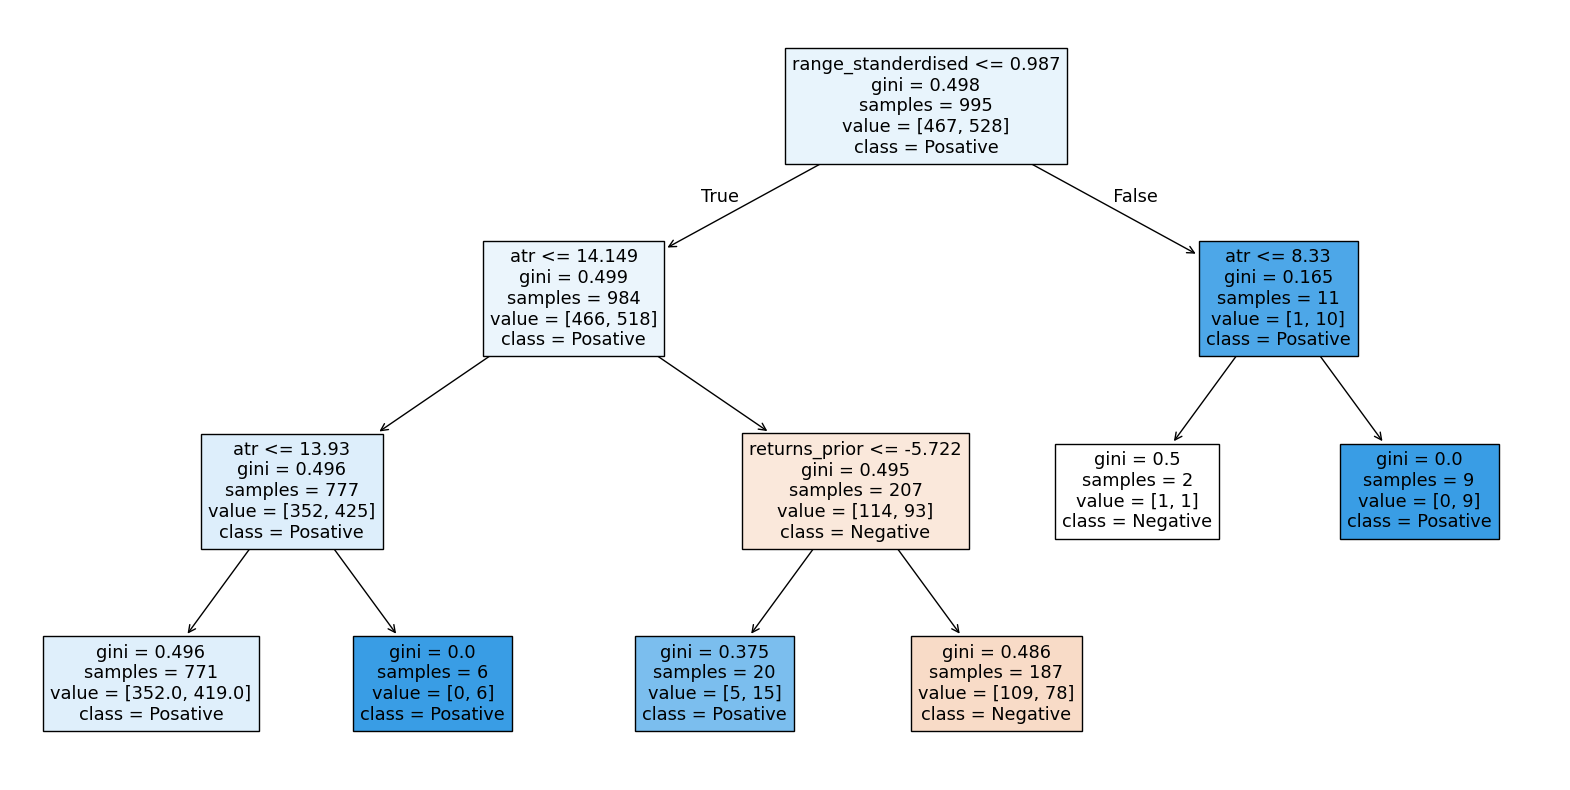

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=ranking_df.iloc[:3, 0].values, class_names=['Negative', 'Posative'])
plt.show()

predict model

In [ ]:
y_pred = clf.predict(X_test_rfe)

evalaute model

In [ ]:
# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# confusion matrix
conf = confusion_matrix(y_test, y_pred)
print('\n confusion matrix \n', conf)

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print('\n class report \n', class_report)

Accuracy: 0.55

 confusion matrix 
 [[  0 112]
 [  0 137]]

 class report 
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       112
    Positive       0.55      1.00      0.71       137

    accuracy                           0.55       249
   macro avg       0.28      0.50      0.35       249
weighted avg       0.30      0.55      0.39       249



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


feature importance

In [ ]:
importances = clf.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns[rfe.support_], 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
2,atr,0.471725
0,returns_prior,0.294200
1,range_standerdised,0.234075


# **Creating a Trading Strategy**

In [ ]:
def decision_tree_leaf_strategy(path, data_path):
    """
    Implements a trading strategy based on the leaf nodes of the provided decision tree.
    Only takes positions when reaching terminal leaf nodes in the tree structure.

    Inputs --------------------------------------
    - ticker (string): stock symbol.
    - start_date (string): start date for data.
    - end_date (string): end date for data.

    Outputs --------------------------------------
    - data (pd.DataFrame): strategy results and calculations
    - ror (float): final strategy return
    - sharpe (float): Sharpe ratio of the strategy
    - alpha (float): The alpha of the strategy
    """

    # Get data
    # data = yf.download(ticker, start=start_date, end=end_date) yfinance, rate limit error
    data = pd.read_csv(data_path)

    # Calculate required features
    data['Prior_Return'] = data['close'].pct_change(1)
    data['Range'] = data['high'] - data['low']
    data['Standardized_Range'] = (data['high'] - data['close']) / (data['high'] - data['low']).replace(0, 0.0001)

    # Calculate ATR (14-day period)
    high = data['high'].values
    low = data['low'].values
    close = data['close'].values
    data['ATR'] = ATR(high, low, close, timeperiod=14)

    # Initialize position column
    data['Position'] = 0  # 0 = no position, 1 = long, -1 = short

    for i in range(1, len(data)):
        range_std = data['Standardized_Range'].iloc[i]
        atr = data['ATR'].iloc[i]
        returns_prior = data['Prior_Return'].iloc[i]

        # Decision tree logic - only taking positions at leaf nodes
        if range_std <= 0.987:
            if atr <= 14.149:
              # left branch (we predict pos for each leag node)
              if atr <= 13.93:
                data.loc[data.index[i], 'Position'] = 1  # Long position
            # right branch
            elif atr > 14.149:
              if returns_prior <= -5.722:
                data.loc[data.index[i], 'Position'] = 1  # Short position
              elif returns_prior > -5.722:
                data.loc[data.index[i], 'Position'] = -1  # Long position
        elif range_std > 0.987:
          if returns_prior <= -2.702:
            data.loc[data.index[i], 'Position'] = 1
          else:
            data.loc[data.index[i], "Position"] = -1

    # Calculate strategy returns (1-day holding period)
    data['Returns'] = data['close'].pct_change()
    data['Strategy_Returns'] = data['Position'].shift(1) * data['Returns']

    # Calculate equity curve and metrics
    data['Equity_Curve'] = (data['Strategy_Returns'] + 1).cumprod() - 1
    data['Equity_Curve_BASELINE'] = (data['Returns'] + 1).cumprod() - 1

    # Adjust returns for commissions
    data['Returns_Adjusted_min'] = np.where(data['Strategy_Returns'] == 0,
                                          data['Strategy_Returns'],
                                          data['Strategy_Returns'] - 0.0001)
    data['Returns_Adjusted_max'] = np.where(data['Strategy_Returns'] == 0,
                                          data['Strategy_Returns'],
                                          data['Strategy_Returns'] - 0.001)
    data['Equity_Curve_Commission_min'] = (data['Returns_Adjusted_min'] + 1).cumprod() - 1
    data['Equity_Curve_Commission_max'] = (data['Returns_Adjusted_max'] + 1).cumprod() - 1

    # Drop NaN values
    data = data.dropna()

    # Final metrics
    ror = data['Equity_Curve'].iloc[-1]
    alpha = data['Equity_Curve'].iloc[-1] - data['Equity_Curve_BASELINE'].iloc[-1]
    sharpe = (data['Strategy_Returns'].mean() / data['Strategy_Returns'].std()) * np.sqrt(252)

    return data, ror, sharpe, alpha

## **Backtest**

To download data see Appendix [1].

In [ ]:
# get data
data_path = r"your_data_path" 
data, ror, sharpe, alpha = decision_tree_leaf_strategy(data_path)

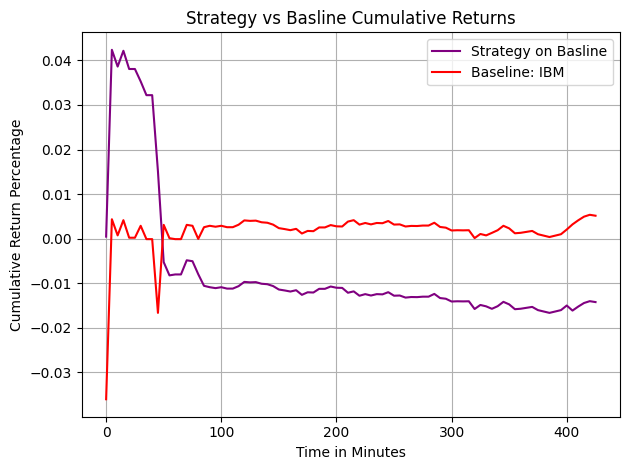

In [ ]:
# time in minutes
x = [i * 5 for i in range(len(data))]

plt.plot(x, data['Equity_Curve'], label='Strategy on Basline', color = 'purple')
plt.plot(x, data['Equity_Curve_BASELINE'], label='Baseline: IBM', color = 'red')
plt.title("Strategy vs Basline Cumulative Returns")
plt.xlabel('Time in Minutes')
plt.ylabel('Cumulative Return Percentage')
plt.grid(True)
plt.legend()
plt.tight_layout()

<ipython-input-20-49a55645ea7e>:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


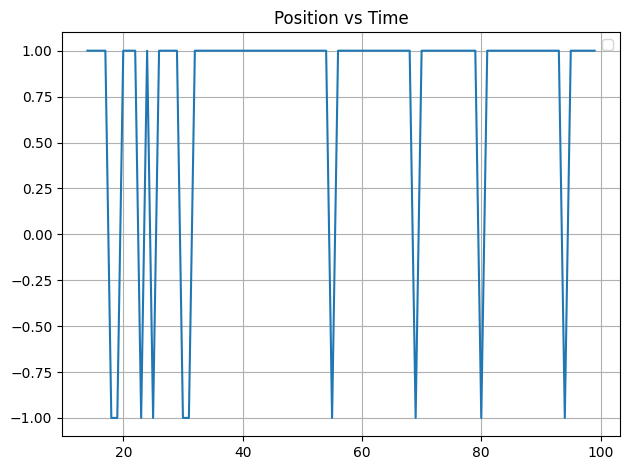

In [ ]:
plt.plot(data['Position'])
plt.title('Position vs Time')
plt.grid(True)
plt.legend()
plt.tight_layout()

## **Appendix** 

[1] - [Download Dataset](https://drive.google.com/drive/folders/1Z63_RkTcDRIwl2rIT-rMB77iWtAkRAbl)